In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dfc615e/en_sample.csv
/kaggle/input/dfc615e/en_data.csv
/kaggle/input/friends/friends_test.json
/kaggle/input/friends/friends_dev.json
/kaggle/input/friends/friends_train.json


In [31]:
data = pd.read_csv("/kaggle/input/dfc615e/en_data.csv", sep=",", encoding="ms949")
sample = pd.read_csv("/kaggle/input/dfc615e/en_sample.csv", sep=",", encoding="ms949")
dev_file = open('/kaggle/input/friends/friends_test.json', encoding="utf-8")
dev_data = json.load(dev_file)
train_file = open('/kaggle/input/friends/friends_train.json', encoding="utf-8")
train_data = json.load(train_file)
test_file = open('/kaggle/input/friends/friends_dev.json', encoding="utf-8")
test_data = json.load(test_file)

In [32]:
data.to_csv("/kaggle/working/en_data.csv", sep=",", index=False)
sample.to_csv("/kaggle/working/en_sample.csv", sep=",", index=False)


In [33]:
data.tail()

,id,i_dialog,i_utterance,speaker,utterance
3291,3291,239,18,Monica,I guess.
3292,3292,239,19,Chandler,"So, shouldn?t we go give her the benefit of th..."
3293,3293,239,20,Monica,Fine. I?m just glad I didn?t give her my secre...
3294,3294,239,21,Chandler,"Out of curiosity, what is your secret ingredient?"
3295,3295,239,22,Monica,Yeah!


In [34]:
df_dev = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])
df_train = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])
df_test = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])

for i in range(len(dev_data)):
    df_dev = pd.concat([df_dev, pd.DataFrame(dev_data[i])])

for i in range(len(train_data)):
    df_train = pd.concat([df_train, pd.DataFrame(train_data[i])])

for i in range(len(test_data)):
    df_test = pd.concat([df_test, pd.DataFrame(test_data[i])])

df_dev = df_dev.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [35]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 랭커스터 스태머의 사용
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

# Lemmatization 음소표기법
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [36]:
stops = set(stopwords.words('english'))

In [37]:
df_dev['words'] = ''
df_train['words'] = ''
df_test['words'] = ''
data['words'] = ''
len(df_dev), len(df_train), len(df_test), len(data)

(2764, 10561, 1178, 3296)

In [38]:
def comment_to_words(data):
    # 1. 영어가 아닌 문자는 공백으로 변환
    data = re.sub('[^a-zA-Z]', ' ', data)
    
    # 2. 소문자로 변환
    lowerdata = data.lower()
    
    # 3. 문자열로 변환
    words = lowerdata.split()
    
    # 4. 불용어 제거
    words = [w for w in words if not w in stops]
    
    # 5. 어간추출
    stemming_words = [stemmer.stem(w) for w in words]
    
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    words = ' '.join(stemming_words)
    return words

In [39]:
data.head()

,id,i_dialog,i_utterance,speaker,utterance,words
0,0,0,0,Phoebe,"Alright, whadyou do with him?",
1,1,0,1,Monica,Oh! You're awake!,
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...,
3,3,0,3,Mr. Tribbiani,"Yeah, but this is",
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!,


In [40]:
# 개발 데이터셋 전처리
for i in range(0, len(df_dev)):
    df_dev.loc[i, 'words'] = comment_to_words(df_dev.loc[i, 'utterance'])

# 훈련 데이터셋 전처리
for i in range(0, len(df_train)):
    df_train.loc[i, 'words'] = comment_to_words(df_train.loc[i, 'utterance'])    

# 테스트 데이터셋 전처리
for i in range(0, len(df_test)):
    df_test.loc[i, 'words'] = comment_to_words(df_test.loc[i, 'utterance'])    
    
# 테스트 데이터셋 전처리
for i in range(0, len(data)):
    data.loc[i, 'words'] = comment_to_words(data.loc[i, 'utterance'])    

In [41]:
y_info = [['neutral', 0],
          ['surprise', 1],
          ['non-neutral', 2],
          ['joy', 3],
          ['sadness', 4],
          ['anger', 5],
          ['disgust', 6]]

y_info = [['neutral', 'neutral'],
          ['surprise', 'surprise'],
          ['non-neutral', 'non-neutral'],
          ['joy', 'joy'],
          ['sadness', 'sadness'],
          ['anger', 'anger'],
          ['disgust', 'disgust']]
        

In [42]:
df_y = pd.DataFrame(y_info, columns=['emotion', 'Y'])

In [43]:
df_dev = pd.merge(df_dev, df_y, on=['emotion'])
df_train = pd.merge(df_train, df_y, on=['emotion'])
df_test = pd.merge(df_test, df_y, on=['emotion'])

In [44]:
df_train.isnull().sum()

annotation    0
emotion       0
speaker       0
utterance     0
words         0
Y             0
dtype: int64

In [45]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [46]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250

# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_dev['words'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 1891 unique tokens.


In [47]:
X = tokenizer.texts_to_sequences(df_train['words'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10376, 250)


In [48]:
X_last = tokenizer.texts_to_sequences(data['words'].values)
X_last = sequence.pad_sequences(X_last, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_last.shape)

Shape of data tensor: (3296, 250)


In [49]:
df_train.head()

,annotation,emotion,speaker,utterance,words,Y
0,4100000,neutral,Chandler,also I was the point person on my companys tr...,also point person compani transit kl gr system,neutral
1,5000000,neutral,The Interviewer,You mustve had your hands full.,must hand full,neutral
2,5000000,neutral,Chandler,That I did. That I did.,,neutral
3,5000000,neutral,The Interviewer,So lets talk a little bit about your duties.,let talk littl bit duti,neutral
4,5000000,neutral,The Interviewer,"Now youll be heading a whole division, so you...",head whole divis lot duti,neutral


In [50]:
Y = pd.get_dummies(df_train['Y']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10376, 7)


In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8300, 250) (8300, 7)
(2076, 250) (2076, 7)


In [52]:
X_train[:5]

array([[  0,   0,   0, ...,  12, 209,  15],
       [  0,   0,   0, ...,   0,  15, 252],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   1,  33],
       [  0,   0,   0, ...,   0,   0,  24]], dtype=int32)

In [53]:
Y_train[:5]

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

In [54]:
EMBEDDING_DIM = 250
MAX_NB_WORDS = len(X_train)

In [55]:
import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, SpatialDropout1D, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
#model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[0]))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 64

MAX_NB_WORDS, EMBEDDING_DIM

(8300, 250)

In [56]:
X_train.shape, Y_train.shape, batch_size

((8300, 250), (8300, 7), 64)

In [57]:
len(Y_train)

8300

In [58]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# history = model.fit(X_train, 
#                     Y_train,
#                    batch_size=batch_size,
#                    verbose=1,
#                    validation_split=0.1)

Epoch 1/3
117/117 [==============================] - 64s 545ms/step - loss: 1.5415 - accuracy: 0.4556 - val_loss: 1.4872 - val_accuracy: 0.4325
Epoch 2/3
117/117 [==============================] - 63s 538ms/step - loss: 1.3857 - accuracy: 0.4950 - val_loss: 1.4581 - val_accuracy: 0.4602
Epoch 3/3
117/117 [==============================] - 64s 544ms/step - loss: 1.2691 - accuracy: 0.5376 - val_loss: 1.4315 - val_accuracy: 0.4602


In [60]:
testpredict = model.predict(X_test)

In [78]:
count = 0
testpredicty = []
testy = []
for i in range(0, len(testpredict)):
    testpredicty.append(np.argmax(testpredict[i]))
    testy.append(np.argmax(Y_test[i]))
    if np.argmax(testpredict[i]) == np.argmax(Y_test[i]):
        count += 1
        
print(count/len(testpredict))    

0.48458574181117536


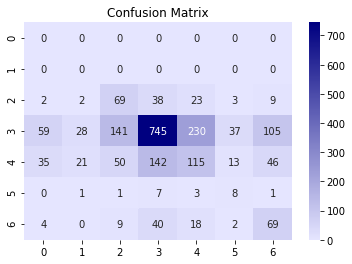

In [80]:
from sklearn.metrics import confusion_matrix
from matplotlib import  pylab as plt
import seaborn as sns

cm = confusion_matrix(testpredicty, testy)
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

In [62]:
predicted = model.predict(X_last)

In [63]:
result = []
result2 = []

for predict in predicted:
    result.append([np.argmax(predict), y_info[np.argmax(predict)][0]])
    result2.append( y_info[np.argmax(predict)][0])

In [64]:
sample['Predicted'] = result2

In [65]:
sample.head()

,Id,Predicted
0,0,joy
1,1,disgust
2,2,joy
3,3,joy
4,4,joy


In [66]:
sample.to_csv("/kaggle/working/result2multiclass2.csv", sep=",", index=False)

In [67]:
sample['Predicted'].value_counts()

joy            2178
sadness         636
disgust         230
non-neutral     199
anger            52
surprise          1
Name: Predicted, dtype: int64